In [1]:
# ==============================================================================
# 1. SETUP E CONFIGURAÇÕES
# ==============================================================================

import os
import time
import zipfile
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.neighbors import NearestNeighbors
import gdown

# --- Parâmetros de Configuração ---

# IDs para download do Google Drive
DATASET_ID = '1Jg8FPCxGPckXMNSlTybxFu5unZCFuW9h'
GT_ID = '10rYRFQAi1AlJDSWAoZK7-SX0D8Kr2oDM'

# Parâmetros de Filtragem da Nuvem
VOXEL_SIZE = 0.5          # Tamanho do voxel para downsampling (em metros)
GROUND_CUT_RATIO = 0.75   # Porcentagem de pontos inferiores a remover (chão/asfalto)

# Parâmetros do Algoritmo ICP
ICP_MAX_ITER = 100        # Número máximo de iterações por par de scans
ICP_TOLERANCE = 1e-6      # Tolerância de erro para considerar convergência
ICP_DIST_THRESH = 0.5     # Distância máxima para aceitar um par de pontos (rejeição de outliers)

# Caminhos de arquivos
DATA_DIR = 'kitti_data'
GT_FILE = 'ground_truth.npy'

print("Bibliotecas e configurações carregadas.")

Bibliotecas e configurações carregadas.


In [2]:
# ==============================================================================
# 2. GERENCIAMENTO DE DADOS (I/O)
# ==============================================================================

def download_and_extract_data():
    # Verifica se os dados já existem para evitar download repetido
    if not os.path.exists('dataset.zip') and not os.path.exists(DATA_DIR):
        print("Baixando dataset...")
        gdown.download(id=DATASET_ID, output='dataset.zip', quiet=False)
        print("Extraindo dataset...")
        with zipfile.ZipFile('dataset.zip', 'r') as zip_ref:
            zip_ref.extractall(DATA_DIR)

    if not os.path.exists(GT_FILE):
        print("Baixando Ground Truth...")
        gdown.download(id=GT_ID, output=GT_FILE, quiet=False)
    print("Dados prontos para uso.")

def load_point_cloud(path):
    # Lê o arquivo .obj e realiza a correção do sistema de coordenadas do KITTI
    # A troca de eixos é necessária pois o KITTI usa Z como frente, mas o obj pode vir com Y
    points = []
    try:
        with open(path, 'r') as f:
            for line in f:
                if line.startswith('v '):
                    parts = line.strip().split()
                    # Realiza a troca: (x, y, z) original -> (x, z, y) novo
                    points.append([float(parts[1]), float(parts[3]), float(parts[2])])
        return np.array(points, dtype=np.float32)
    except Exception as e:
        print(f"Erro ao ler o arquivo {path}: {e}")
        return np.zeros((0, 3))

def get_scan_files():
    # Retorna uma lista ordenada com o caminho de todos os arquivos .obj
    files = sorted([
        os.path.join(r, f)
        for r, d, fs in os.walk(DATA_DIR)
        for f in fs if f.endswith('.obj')
    ])
    return files

# Executa o download inicial
download_and_extract_data()

Baixando dataset...


Downloading...
From: https://drive.google.com/uc?id=1Jg8FPCxGPckXMNSlTybxFu5unZCFuW9h
To: /content/dataset.zip
100%|██████████| 18.0M/18.0M [00:00<00:00, 38.1MB/s]


Extraindo dataset...
Baixando Ground Truth...


Downloading...
From: https://drive.google.com/uc?id=10rYRFQAi1AlJDSWAoZK7-SX0D8Kr2oDM
To: /content/ground_truth.npy
100%|██████████| 3.97k/3.97k [00:00<00:00, 15.2MB/s]

Dados prontos para uso.


In [3]:
# ==============================================================================
# 3. PRÉ-PROCESSAMENTO (FILTROS)
# ==============================================================================

def filter_remove_ground(points, cut_ratio=0.75):
    # Remove uma porcentagem dos pontos mais baixos (eixo Y/altura)
    # Isso é fundamental para que o ICP não tente alinhar o asfalto (plano infinito)
    # e foque em objetos geométricos distintos (muros, carros, postes).
    if len(points) == 0:
        return points

    # Ordena indices baseado na altura (coluna 1, que é o Y após a correção)
    sorted_indices = np.argsort(points[:, 1])
    cut_idx = int(len(sorted_indices) * cut_ratio)

    # Retorna apenas os pontos da parte superior
    keep_indices = sorted_indices[cut_idx:]
    return points[keep_indices, :]

def filter_voxel_grid(points, voxel_size=0.5):
    # Simplifica a nuvem mantendo apenas um ponto representativo por voxel cúbico.
    # Isso uniformiza a densidade da nuvem (evita peso excessivo em moitas/árvores)
    # e reduz o custo computacional do ICP.
    if len(points) == 0:
        return points

    # Discretiza as coordenadas dividindo pelo tamanho do voxel e arredondando
    voxel_indices = (points / voxel_size).astype(int)

    # Encontra os índices únicos (mantém apenas a primeira ocorrência em cada cubo)
    _, unique_indices = np.unique(voxel_indices, axis=0, return_index=True)

    return points[unique_indices]

In [4]:
# ==============================================================================
# 4. ALGORITMO ICP E MATEMÁTICA
# ==============================================================================

def compute_svd_transform(A, B):
    # Calcula a matriz de transformação rígida 4x4 que melhor alinha
    # os pontos de origem A aos pontos de destino B usando SVD.

    # Calcula os centróides
    centroid_A = np.mean(A, axis=0)
    centroid_B = np.mean(B, axis=0)

    # Centraliza as nuvens
    AA = A - centroid_A
    BB = B - centroid_B

    # Matriz de Covariância Cruzada
    H = np.dot(AA.T, BB)

    # Decomposição de Valor Singular (SVD)
    U, S, Vt = np.linalg.svd(H)

    # Matriz de Rotação
    R = np.dot(Vt.T, U.T)

    # Correção para o caso de reflexão (determinante negativo)
    if np.linalg.det(R) < 0:
        Vt[2, :] *= -1
        R = np.dot(Vt.T, U.T)

    # Vetor de Translação
    t = centroid_B.T - np.dot(R, centroid_A.T)

    # Montagem da Matriz Homogênea Final (4x4)
    T = np.identity(4)
    T[:3, :3] = R
    T[:3, 3] = t
    return T

def run_icp(source, target, max_iter, tolerance, dist_thresh):
    # Algoritmo Iterative Closest Point com rejeição de correspondências ruins.

    src = source.copy()
    dst = target.copy()

    # Cria coordenadas homogêneas para facilitar operações matriciais
    src_h = np.ones((src.shape[0], 4))
    src_h[:, :3] = src

    T_final = np.eye(4)
    prev_error = float('inf')

    # Usa KD-Tree para busca eficiente do vizinho mais próximo
    nbrs = NearestNeighbors(n_neighbors=1, algorithm='kd_tree').fit(dst)

    for i in range(max_iter):
        # 1. Encontrar o ponto mais próximo no destino para cada ponto na origem
        src_curr = src_h[:, :3]
        distances, indices = nbrs.kneighbors(src_curr)

        # Achatar arrays para processamento
        distances = distances.ravel()
        indices = indices.ravel()

        # 2. Rejeição de Outliers
        # Criamos uma máscara booleana para ignorar pontos cuja distância
        # para o vizinho seja maior que o limiar (dist_thresh).
        # Isso evita que pontos sem correspondência "puxem" o alinhamento errado.
        mask = distances < dist_thresh

        # Verificação de segurança para não rodar SVD com poucos pontos
        if np.sum(mask) < 50:
            break

        src_good = src_curr[mask]
        dst_good = dst[indices][mask]

        # 3. Calcular a transformação ótima para este passo
        T_step = compute_svd_transform(src_good, dst_good)

        # 4. Aplicar a transformação aos pontos da origem
        src_h = (np.dot(T_step, src_h.T)).T

        # Acumular a transformação na matriz final
        T_final = np.dot(T_step, T_final)

        # 5. Verificar convergência (baseado no erro médio dos inliers)
        mean_error = np.mean(distances[mask])
        if np.abs(prev_error - mean_error) < tolerance:
            break
        prev_error = mean_error

    return T_final

In [8]:
# ==============================================================================
# 5. ENGINE DE ODOMETRIA
# ==============================================================================

def run_visual_odometry(scan_paths):
    # Processa a sequência de arquivos para estimar a trajetória completa.
    # Utiliza um Modelo de Velocidade Constante para o 'chute inicial' do ICP.

    print(f"Iniciando odometria em {len(scan_paths)} frames...")

    # Inicialização das matrizes de pose
    current_pose = np.eye(4)
    trajectory = [current_pose]

    # Matriz para guardar a velocidade (transformação) do passo anterior
    last_velocity_T = np.eye(4)

    start_time = time.time()

    for i in range(len(scan_paths) - 1):
        # A. Carregamento das nuvens bruta
        source_raw = load_point_cloud(scan_paths[i])
        target_raw = load_point_cloud(scan_paths[i+1])

        # B. Aplicação dos Filtros (Remoção de chão e Voxel Grid)
        source_clean = filter_voxel_grid(
            filter_remove_ground(source_raw, cut_ratio=GROUND_CUT_RATIO),
            voxel_size=VOXEL_SIZE
        )
        target_clean = filter_voxel_grid(
            filter_remove_ground(target_raw, cut_ratio=GROUND_CUT_RATIO),
            voxel_size=VOXEL_SIZE
        )

        # C. Predição de Movimento (Chute Inicial)
        # Assumimos que o carro continua o movimento anterior.
        # Aplicamos essa transformação na nuvem de origem para aproximá-la do alvo.
        R_pred = last_velocity_T[:3, :3]
        t_pred = last_velocity_T[:3, 3]
        source_predicted = np.dot(source_clean, R_pred.T) + t_pred

        # D. Refinamento com ICP
        # O ICP calcula apenas o "ajuste fino" (erro residual) entre a predição e o alvo.
        T_correction = run_icp(
            source_predicted,
            target_clean,
            max_iter=ICP_MAX_ITER,
            tolerance=ICP_TOLERANCE,
            dist_thresh=ICP_DIST_THRESH
        )

        # E. Composição do Movimento Total
        # Movimento Real = Correção do ICP * Predição de Velocidade
        T_step = np.dot(T_correction, last_velocity_T)

        # F. Atualização da Pose Global
        # A pose global acumula a inversa da transformação relativa (Carro no Mundo)
        current_pose = np.dot(current_pose, np.linalg.inv(T_step))
        trajectory.append(current_pose)

        # Atualiza a velocidade para ser usada como chute no próximo frame
        last_velocity_T = T_step

        print(f" -> Frame {i} processado. Pontos ativos: {len(source_clean)}")

    print(f"Concluído em {time.time() - start_time:.2f} segundos.")
    return np.array(trajectory)

In [6]:
# ==============================================================================
# 6. VISUALIZAÇÃO E MÉTRICAS
# ==============================================================================

def calculate_error(estimated, ground_truth):
    # Calcula o erro de translação euclidiana (em metros) na posição final
    pos_est = estimated[-1, :3, 3]
    pos_gt = ground_truth[-1, :3, 3]
    return np.linalg.norm(pos_gt - pos_est)

def plot_trajectory_3d(estimated, ground_truth):
    # Plota as trajetórias real e estimada em 3D
    est_xyz = estimated[:, :3, 3]
    gt_xyz = ground_truth[:, :3, 3]

    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Plot Ground Truth (Verde)
    # Nota: No plot 3D do matplotlib, às vezes invertemos eixos para facilitar a visualização
    ax.plot(gt_xyz[:,0], gt_xyz[:,2], -gt_xyz[:,1],
            c='green', label='Ground Truth', linewidth=2, marker='o', markersize=3)

    # Plot Estimado (Vermelho)
    ax.plot(est_xyz[:,0], est_xyz[:,2], -est_xyz[:,1],
            c='red', label='ICP Estimado', linewidth=2, linestyle='--', marker='x', markersize=3)

    ax.set_title(f'Trajetória 3D do Veículo')
    ax.set_xlabel('Eixo X (Lateral)')
    ax.set_ylabel('Eixo Z (Frente)')
    ax.set_zlabel('Eixo Y (Altura)')
    ax.legend()
    plt.show()

def print_results(estimated_path, gt_poses):
    error = calculate_error(estimated_path, gt_poses)

    print("\n" + "="*50)
    print("RELATÓRIO FINAL")
    print("="*50)
    print(f"Posição Final Real (GT):     {gt_poses[-1, :3, 3]}")
    print(f"Posição Final Estimada:      {estimated_path[-1, :3, 3]}")
    print(f"Erro de Posição Final:       {error:.4f} metros")
    print("-" * 50)
    print("Matriz de Transformação Final (Homogênea):")
    print(estimated_path[-1])
    print("="*50)

Iniciando odometria em 30 frames...
 -> Frame 0 processado. Pontos ativos: 1000
 -> Frame 1 processado. Pontos ativos: 990
 -> Frame 2 processado. Pontos ativos: 981
 -> Frame 3 processado. Pontos ativos: 984
 -> Frame 4 processado. Pontos ativos: 932
 -> Frame 5 processado. Pontos ativos: 905
 -> Frame 6 processado. Pontos ativos: 894
 -> Frame 7 processado. Pontos ativos: 900
 -> Frame 8 processado. Pontos ativos: 785
 -> Frame 9 processado. Pontos ativos: 790
 -> Frame 10 processado. Pontos ativos: 792
 -> Frame 11 processado. Pontos ativos: 848
 -> Frame 12 processado. Pontos ativos: 937
 -> Frame 13 processado. Pontos ativos: 1033
 -> Frame 14 processado. Pontos ativos: 1083
 -> Frame 15 processado. Pontos ativos: 1090
 -> Frame 16 processado. Pontos ativos: 1102
 -> Frame 17 processado. Pontos ativos: 1082
 -> Frame 18 processado. Pontos ativos: 1149
 -> Frame 19 processado. Pontos ativos: 1142
 -> Frame 20 processado. Pontos ativos: 1170
 -> Frame 21 processado. Pontos ativos: 1

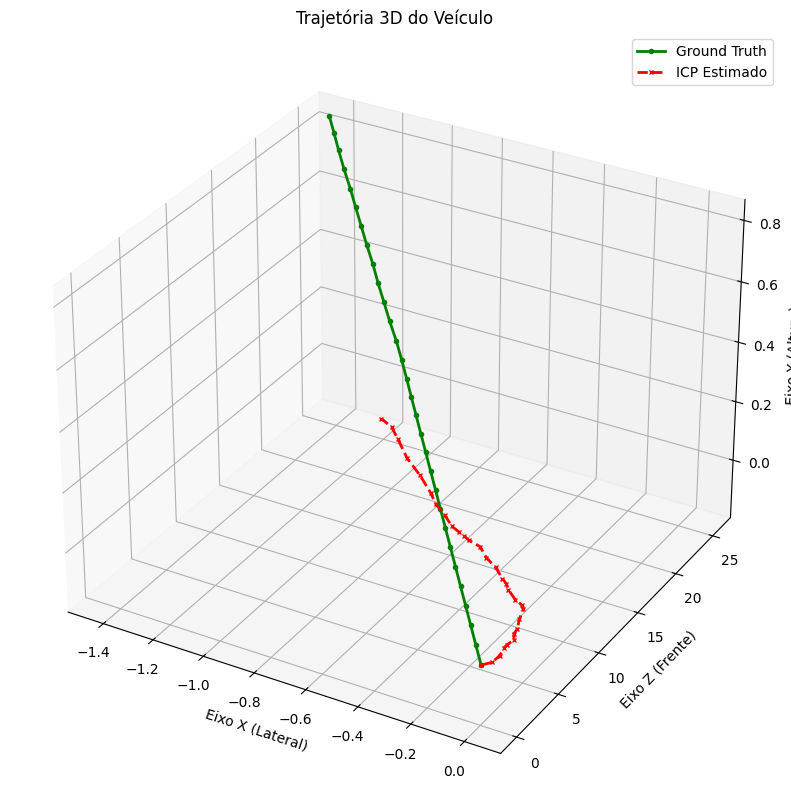


RELATÓRIO FINAL
Posição Final Real (GT):     [-1.436633  -0.8456208 25.59694  ]
Posição Final Estimada:      [-1.20494852  0.12488717 24.90470754]
Erro de Posição Final:       1.2144 metros
--------------------------------------------------
Matriz de Transformação Final (Homogênea):
[[ 9.98347888e-01 -6.53614578e-04 -5.74549190e-02 -1.20494852e+00]
 [ 7.99327101e-04  9.99996523e-01  2.51317417e-03  1.24887169e-01]
 [ 5.74530765e-02 -2.55494740e-03  9.98344939e-01  2.49047075e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [9]:
# ==============================================================================
# 7. EXECUÇÃO PRINCIPAL
# ==============================================================================

# 1. Obter lista de arquivos do diretório
files = get_scan_files()

if len(files) == 0:
    print("Nenhum arquivo encontrado. Verifique o download.")
else:
    # 2. Rodar o pipeline de Odometria
    final_trajectory = run_visual_odometry(files)

    # 3. Carregar e comparar com o Ground Truth
    if os.path.exists(GT_FILE):
        ground_truth_data = np.load(GT_FILE)

        # 4. Exibir Gráficos e Resultados Numéricos
        plot_trajectory_3d(final_trajectory, ground_truth_data)
        print_results(final_trajectory, ground_truth_data)
    else:
        print("Arquivo de Ground Truth não encontrado.")